# Project - Mobile recommender system

In [1]:
import networkx as nx 
import pandas as pd
import numpy as numpy
import random
from tqdm import tqdm
from sklearn.decomposition import PCA
from ge import DeepWalk
import matplotlib.pyplot as plt
import warnings
import pickle
warnings.filterwarnings('ignore')

In [2]:
path = '/Volumes/Library/SynologyDrive/data/AI_Cheats/fresh_comp_offline'

In [4]:
# 数据加载
df = pd.read_csv(path+'/tianchi_fresh_comp_train_user.csv')
df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,10001082,285259775,1,97lk14c,4076,2014-12-08 18
1,10001082,4368907,1,NaN,5503,2014-12-12 12
2,10001082,4368907,1,NaN,5503,2014-12-12 12
3,10001082,53616768,1,NaN,9762,2014-12-02 15
4,10001082,151466952,1,NaN,5232,2014-12-12 11


In [17]:
# 2014 年 12 月 19 日
# 设置解析
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d %H')
file_name = path+'/tianchi_fresh_comp_train_user.csv'
batch = 0
for df in pd.read_csv(open(file_name, 'r'), parse_dates=['time'],
      index_col=['time'],
      date_parser = dateparse,
      chunksize = 1000000):
  # 关注 behavior_type = 3 或 4
  df_act_34 = df[df['behavior_type'].isin([3, 4])]
  # 如果想要追加文件的话，设置 mode=a
  df_act_34.to_csv(path+'/act_34.csv', columns=['user_id', 'item_id', 'behavior_type', 'item_category'], header=False, mode='a')
  batch = batch + 1
  print('chunk {} done'.format(batch))

chunk 1 done
chunk 2 done
chunk 3 done
chunk 4 done
chunk 5 done
chunk 6 done
chunk 7 done
chunk 8 done
chunk 9 done
chunk 10 done
chunk 11 done
chunk 12 done
chunk 13 done
chunk 14 done
chunk 15 done
chunk 16 done
chunk 17 done
chunk 18 done
chunk 19 done
chunk 20 done
chunk 21 done
chunk 22 done
chunk 23 done
chunk 24 done


In [5]:
df_act_34 = df[df['behavior_type'].isin([3,4])]
df_act_34.to_pickle(path+'/df_act_34.pkl')

In [7]:
%%time
with open(path+'/df_act_34.pkl', 'rb') as file:
  df_act_34 = pickle.load(file)
df_act_34.head()
  

CPU times: user 50.2 ms, sys: 26.6 ms, total: 76.9 ms
Wall time: 102 ms


,user_id,item_id,behavior_type,user_geohash,item_category,time
5,10001082,53616768,4,NaN,9762,2014-12-02 15
61,10001082,220586551,4,NaN,7079,2014-12-14 03
83,10001082,275221686,4,NaN,10576,2014-12-02 22
140,10001082,141312432,4,NaN,12097,2014-12-02 16
212,100029775,287413918,4,NaN,5689,2014-12-13 00


In [10]:
df_act_34.sort_values(by=['time'], ascending=True, inplace=True)

In [11]:
df_act_34.drop_duplicates(['user_id', 'item_id', 'behavior_type'], keep='last', inplace=True)
df_act_34.info()

<class 'pandas.core.frame.DataFrame'>
Index: 742625 entries, 4800050 to 17572800
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        742625 non-null  int64 
 1   item_id        742625 non-null  int64 
 2   behavior_type  742625 non-null  int64 
 3   user_geohash   231386 non-null  object
 4   item_category  742625 non-null  int64 
 5   time           742625 non-null  object
dtypes: int64(4), object(2)
memory usage: 39.7+ MB


In [12]:
# 所有 behavior_type = 3 的数据
df_time_3 = df_act_34[df_act_34['behavior_type'] == 3][['user_id', 'item_id', 'time']]
df_time_3

,user_id,item_id,time
4800050,28165193,265632338,2014-11-18 00
15802187,10449549,328490384,2014-11-18 00
1953733,123035069,81119053,2014-11-18 00
15802118,10449549,35909364,2014-11-18 00
1954625,123035069,247143043,2014-11-18 00
...,...,...,...
9281424,11428002,292043587,2014-12-18 23
2724065,131856122,92695700,2014-12-18 23
4296096,22586157,274614952,2014-12-18 23
5905065,40796353,367859704,2014-12-18 23


In [13]:
# 所有 behavior_type = 4 的数据
df_time_4 = df_act_34[df_act_34['behavior_type'] == 4][['user_id', 'item_id', 'time']]
df_time_4

,user_id,item_id,time
1953531,123035069,377002409,2014-11-18 00
1953975,123035069,131377208,2014-11-18 00
1954294,123035069,73193732,2014-11-18 00
1954311,123035069,365586641,2014-11-18 00
1954377,123035069,247143043,2014-11-18 00
...,...,...,...
5905544,40802089,250138552,2014-12-18 23
3162677,137213418,221117213,2014-12-18 23
19135739,15913825,355261504,2014-12-18 23
12686589,29396660,62536729,2014-12-18 23


In [14]:
df_time_3.rename(columns={'time':'time3'}, inplace=True)
df_time_4.rename(columns={'time':'time4'}, inplace=True)

In [15]:
df_time_3

,user_id,item_id,time3
4800050,28165193,265632338,2014-11-18 00
15802187,10449549,328490384,2014-11-18 00
1953733,123035069,81119053,2014-11-18 00
15802118,10449549,35909364,2014-11-18 00
1954625,123035069,247143043,2014-11-18 00
...,...,...,...
9281424,11428002,292043587,2014-12-18 23
2724065,131856122,92695700,2014-12-18 23
4296096,22586157,274614952,2014-12-18 23
5905065,40796353,367859704,2014-12-18 23


In [16]:
df_time = pd.merge(df_time_3, df_time_4, on = ['user_id', 'item_id'], how='left')
df_time

,user_id,item_id,time3,time4
0,28165193,265632338,2014-11-18 00,NaN
1,10449549,328490384,2014-11-18 00,NaN
2,123035069,81119053,2014-11-18 00,NaN
3,10449549,35909364,2014-11-18 00,NaN
4,123035069,247143043,2014-11-18 00,2014-11-18 00
...,...,...,...,...
542801,11428002,292043587,2014-12-18 23,NaN
542802,131856122,92695700,2014-12-18 23,NaN
542803,22586157,274614952,2014-12-18 23,NaN
542804,40796353,367859704,2014-12-18 23,NaN


In [17]:
df_time_34 = df_time.dropna()
df_time_34

,user_id,item_id,time3,time4
4,123035069,247143043,2014-11-18 00,2014-11-18 00
7,123035069,365586641,2014-11-18 00,2014-11-18 00
10,123035069,66568628,2014-11-18 00,2014-11-18 00
11,123035069,247136503,2014-11-18 00,2014-12-08 12
17,129403050,139275009,2014-11-18 00,2014-11-18 21
...,...,...,...,...
542695,110507044,191016161,2014-12-18 23,2014-12-18 23
542726,107902802,127132351,2014-12-18 23,2014-12-18 23
542774,4488725,77476550,2014-12-18 23,2014-11-29 15
542781,18917491,11883888,2014-12-18 23,2014-12-14 14


In [18]:
# 计算从加购 => 购买的时间差
# 使用pd.to_datetime 转换时间格式
delta_time = pd.to_datetime(df_time_34['time4']) - pd.to_datetime(df_time_34['time3'])
delta_time

4           0 days 00:00:00
7           0 days 00:00:00
10          0 days 00:00:00
11         20 days 12:00:00
17          0 days 21:00:00
                ...        
542695      0 days 00:00:00
542726      0 days 00:00:00
542774   -20 days +16:00:00
542781    -5 days +15:00:00
542788    -3 days +01:00:00
Length: 115705, dtype: timedelta64[ns]

In [22]:
delta_hour = []
for i in range(len(delta_time)):
  d_hour = delta_time.iloc[i].days * 24 + delta_time.iloc[i]._h
  if d_hour<0:
    continue
  else:
    delta_hour.append(d_hour)
delta_hour

[0,
 0,
 0,
 480,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 24,
 0,
 0,
 0,
 0,
 216,
 0,
 0,
 72,
 0,
 528,
 216,
 0,
 0,
 480,
 0,
 24,
 0,
 240,
 24,
 0,
 0,
 72,
 0,
 0,
 0,
 0,
 0,
 24,
 0,
 0,
 0,
 0,
 24,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 216,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 192,
 0,
 0,
 0,
 0,
 192,
 24,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 336,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 216,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 72,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 48,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 216,
 0,
 0,
 0,
 24,
 24,
 0,
 0,
 0,
 96,
 48,
 48,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 120,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 48,
 0,
 0,
 504,
 0,
 0,
 48,
 0,
 0,
 168,
 0,
 0,
 24,
 0,
 0,
 0,
 0,
 24,
 0,
 12

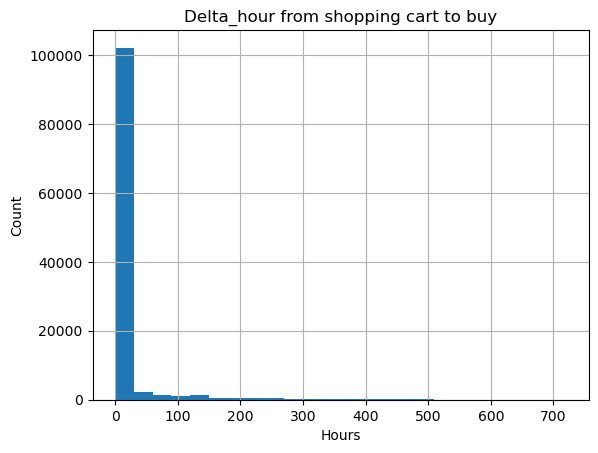

In [23]:
plt.hist(delta_hour, bins=24)
plt.xlabel('Hours')
plt.ylabel('Count')
plt.title('Delta_hour from shopping cart to buy')
plt.grid(True)
plt.show()

In [80]:
# 查看2014-12-18，当时放到购物车中的用户
ui_pred = df_time[df_time['time4'].isnull() & (df_time['time3'] >= '2014-12-18 00')]
ui_pred

,user_id,item_id,time3,time4
524908,3271027,389165078,2014-12-18 00,NaN
524909,22711728,374413445,2014-12-18 00,NaN
524910,57357240,37430246,2014-12-18 00,NaN
524911,115191881,88647733,2014-12-18 00,NaN
524912,115191881,5956898,2014-12-18 00,NaN
...,...,...,...,...
542800,112633315,113560936,2014-12-18 23,NaN
542802,18917491,149208683,2014-12-18 23,NaN
542803,46079366,384591257,2014-12-18 23,NaN
542804,46877765,182645513,2014-12-18 23,NaN


In [81]:
# 只看商品子集的购买情况
df_item = pd.read_csv(path+'/tianchi_fresh_comp_train_item.csv')
df_item
ui_pred_in_p = pd.merge(ui_pred, df_item, on='item_id')
ui_pred_in_p

,user_id,item_id,time3,time4,item_geohash,item_category
0,115594814,198274022,2014-12-18 00,NaN,NaN,10431
1,11436462,393177247,2014-12-18 00,NaN,NaN,8678
2,120013993,354301164,2014-12-18 00,NaN,NaN,5932
3,115594814,248031234,2014-12-18 00,NaN,NaN,10431
4,40387240,351069490,2014-12-18 00,NaN,NaN,10576
...,...,...,...,...,...,...
1427,122645273,346551228,2014-12-18 23,NaN,NaN,8561
1428,103582819,104794920,2014-12-18 23,NaN,NaN,9205
1429,30293799,252876827,2014-12-18 23,NaN,NaN,11422
1430,136286592,341533485,2014-12-18 23,NaN,NaN,12170


In [83]:
ui_pred_in_p.to_csv(path+'/baseline_rulebased.csv', columns = ['user_id', 'item_id'], index=False)

In [84]:
pd.read_csv(path+"/baseline_rulebased.csv")

,user_id,item_id
0,115594814,198274022
1,11436462,393177247
2,120013993,354301164
3,115594814,248031234
4,40387240,351069490
...,...,...
1427,122645273,346551228
1428,103582819,104794920
1429,30293799,252876827
1430,136286592,341533485
